# Algoritmos Genéticos Para Otimizar Rede de Entregadores

Objetivo: Dados uma seria de pedidos contento posições de origem e destino e tendo a localização dos entregadores, otimizar a alaocação dos entregadores de forma a atender os requisitos:

1. Reduzir a kilometragem geral percorrida pelos entregadores

Grupo: 

- André Jackson Gomes Bessa - RM356320 - andrebessa@gmail.com
- Guilherme Silva - RM354130 - s.guisanto079@gmail.com
- Jose Eduardo - RM355857 - jeduardo.miranda@gmail.com
- Thiago - RM353588 - thiagodesa26@gmail.com


In [229]:
from deap import base, creator, tools
from geopy.distance import geodesic # Para calcular distâncias entre pontos geográficos
import numpy as np
import pandas as pd
import random


In [230]:
# import os

# # Listar o conteúdo do diretório corrente
# conteudo_diretorio = os.listdir('.')

# # Exibir o conteúdo
# for item in conteudo_diretorio:
#     print(item)


# e = pd.read_csv("entregadores.csv")
# len(e)

In [231]:
# Definir os entregadores
entregadores = [
    {"id": 1, "localizacao": ( -23.55, -46.64 )}, 
    {"id": 2, "localizacao": ( -22.91, -43.21 )},
    {"id": 3, "localizacao": ( -23.91, -41.21 )},
    {"id": 4, "localizacao": ( -25.91, -44.21 )},
    {"id": 5, "localizacao": ( -26.91, -46.21 )}
]

# Definir os pedidos
pedidos = [
    {"id": 1, "origem": ( -23.56, -39.63 ), "destino": ( -33.57, -46.62 )}, 
    {"id": 2, "origem": ( -22.90, -40.20 ), "destino": ( -32.89, -45.19 )},
    {"id": 3, "origem": ( -21.90, -46.20 ), "destino": ( -31.89, -46.19 )},
    {"id": 4, "origem": ( -24.90, -45.20 ), "destino": ( -30.89, -43.19 )},
    {"id": 5, "origem": ( -25.90, -44.20 ), "destino": ( -29.89, -42.19 )},
    {"id": 6, "origem": ( -26.90, -43.20 ), "destino": ( -28.89, -40.19 )},
    {"id": 7, "origem": ( -27.90, -42.20 ), "destino": ( -27.89, -39.19 )},
    {"id": 8, "origem": ( -28.90, -43.20 ), "destino": ( -23.89, -38.19 )},
    {"id": 9, "origem": ( -30.90, -40.20 ), "destino": ( -28.89, -37.19 )},
    {"id": 10, "origem": ( -25.90, -40.20 ), "destino": ( -21.89, -35.19 )}
]

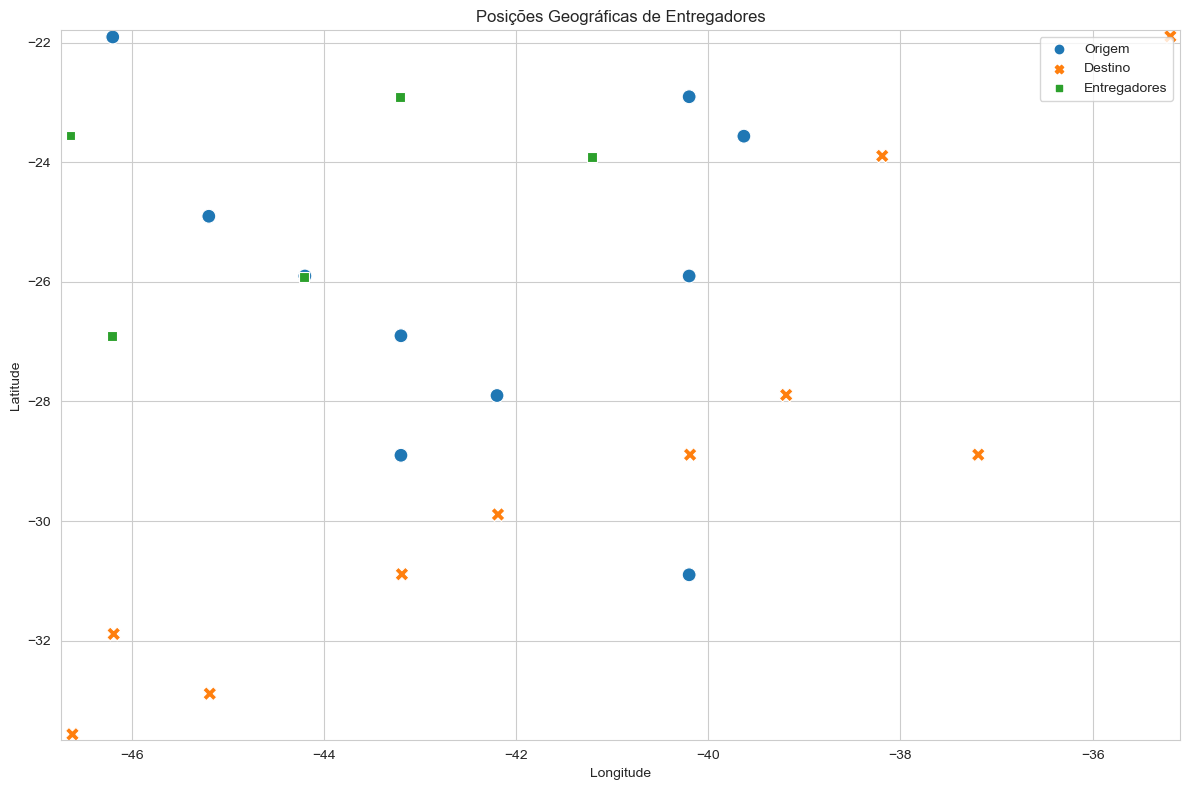

In [232]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import copy

origens = [pedido['origem'] for pedido in pedidos]
destinos = [pedido['destino'] for pedido in pedidos]
localizacoes_entregadores = [entregador['localizacao'] for entregador in entregadores]


# Suponha que você tenha os dados em listas ou dicionários
# origens = [(lat1, lon1), (lat2, lon2), ...]
# destinos = [(lat1, lon1), (lat2, lon2), ...]

# Criar DataFrames para origens e destinos
df_origens = pd.DataFrame(origens, columns=['Latitude', 'Longitude'])
df_origens['Tipo'] = 'Origem'

df_destinos = pd.DataFrame(destinos, columns=['Latitude', 'Longitude'])
df_destinos['Tipo'] = 'Destino'

df_entregadores = pd.DataFrame(localizacoes_entregadores, columns=['Latitude', 'Longitude'])
df_entregadores['Tipo'] = 'Entregadores'

# Combinar os DataFrames
df = pd.concat([df_origens, df_destinos, df_entregadores])

# Criar o gráfico
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Longitude', y='Latitude', hue='Tipo', style='Tipo', s=100)

# # Adicionar linhas conectando origens e destinos
# for (orig_lat, orig_lon), (dest_lat, dest_lon) in zip(origens, destinos):
#     plt.plot([orig_lon, dest_lon], [orig_lat, dest_lat], 'b-', linewidth=0.5, alpha=0.5)

# Personalizar o gráfico
plt.title('Posições Geográficas de Entregadores')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='')

# Ajustar os limites do gráfico para mostrar todas as posições
plt.xlim(df['Longitude'].min() - 0.1, df['Longitude'].max() + 0.1)
plt.ylim(df['Latitude'].min() - 0.1, df['Latitude'].max() + 0.1)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

In [233]:
# Gerando uma lista randomica distribuíndo um entregador para cada pedido
def entregador_pedido():
    chromossome = []
    max = int(len(pedidos)/len(entregadores))
    map_max = {}

    for i in range(len(entregadores)):
        map_max[i+1] = max

    while len(chromossome) < len(pedidos):
        entregador = random.choice(range(1, len(entregadores)+1))

        if map_max[entregador] != 0:
            chromossome.append(entregador)
            map_max[entregador] -= 1
    
    return chromossome

In [234]:
entregador_pedido()


[4, 3, 3, 5, 2, 5, 4, 2, 1, 1]

In [235]:
# Definir a função de fitness
# O atributo individuo é um objeto da classe Individuo
def fitness_function(individuo):
    total_distancia = 0
    chromossome = individuo[0]
    
    map_entregador_origem = {}
    data_stream = []

    #For que inderaja em uma lista e apresente a posicação da lista e o valor da posicação
    for pedido_id, entregador_id in enumerate(chromossome):
        pedido = pedidos[pedido_id] # Ajustar índice para começar de 0
        entregador = entregadores[entregador_id - 1]

        if entregador_id not in map_entregador_origem:
            map_entregador_origem[entregador_id] = entregador["localizacao"]

        entrega =  (map_entregador_origem[entregador_id], pedido["origem"], pedido["destino"])
        map_entregador_origem[entregador_id] = pedido["destino"]
        data_stream.append(entrega)


    for entrega in data_stream: 
        total_distancia += geodesic(entrega[1], entrega[0]).km
        total_distancia += geodesic(entrega[2], entrega[1]).km

    return total_distancia,  # Retorna um tuple com o fitness

In [236]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Criar o toolbox DEAP
toolbox = base.Toolbox()

# Configurar o toolbox
toolbox.register("entregador_pedido", entregador_pedido)

# Um individuo é uma lista com o número de posicoes cada um referente a um pedido e o valor de cada posição é o entregador que vai entregar o pedido
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.entregador_pedido, n=1)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness_function)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/homebrew/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [237]:
# Criar a população inicial com 4 individuos
# toolbox.population(n=4)


In [238]:
# CXPB  prpbabilidade de crossover entre dois individuos
#
# MUTPB probabilidade de mutação de um individuo
def execute(tamanho_populacao = 10, cxpb = 0.5, mutpb = 0.2, ngen = 5000):
    populacao = toolbox.population(n=tamanho_populacao)
    results =  {}

    # Avalia população
    fitnesses = list(map(toolbox.evaluate, populacao))
    for ind, fit in zip(populacao, fitnesses):
        ind.fitness.values = fit

    # Extraingdo os valores de fitness
    fits = [ind.fitness.values[0] for ind in populacao]

    # Controla o número de gerações
    g = 0

    # Inicia evolução
    while g < ngen:
        g = g + 1

        # Seleciona os individuos para cruzamento
        offspring = toolbox.select(populacao, len(populacao))

        # Clona os individuos selecionados
        offspring = list(map(toolbox.clone, offspring))

        # Aplica crossover e mutação
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.mate(child1[0], child2[0])
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < mutpb:
                toolbox.mutate(mutant[0])
                del mutant.fitness.values

        # Checa os individuos com fitness inválido
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
            
        populacao[:] = offspring
    
        # Extrai os valores de fitness dos individuos da população
        fits = [ind.fitness.values[0] for ind in populacao]
        
        # length = len(populacao)
        # mean = sum(fits) / length
        # sum2 = sum(x*x for x in fits)
        # std = abs(sum2 / length - mean**2)**0.5
        
        # print(min(fits), max(fits), mean, std)
        results[g] = populacao[np.argmin([sum(toolbox.evaluate(x)) for x in populacao])]

    return results
       
results = execute()
print(results[5000])
print(results[5000].fitness.values[0])

[[2, 3, 1, 5, 4, 3, 3, 4, 5, 3]]
9803.9655757215


/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


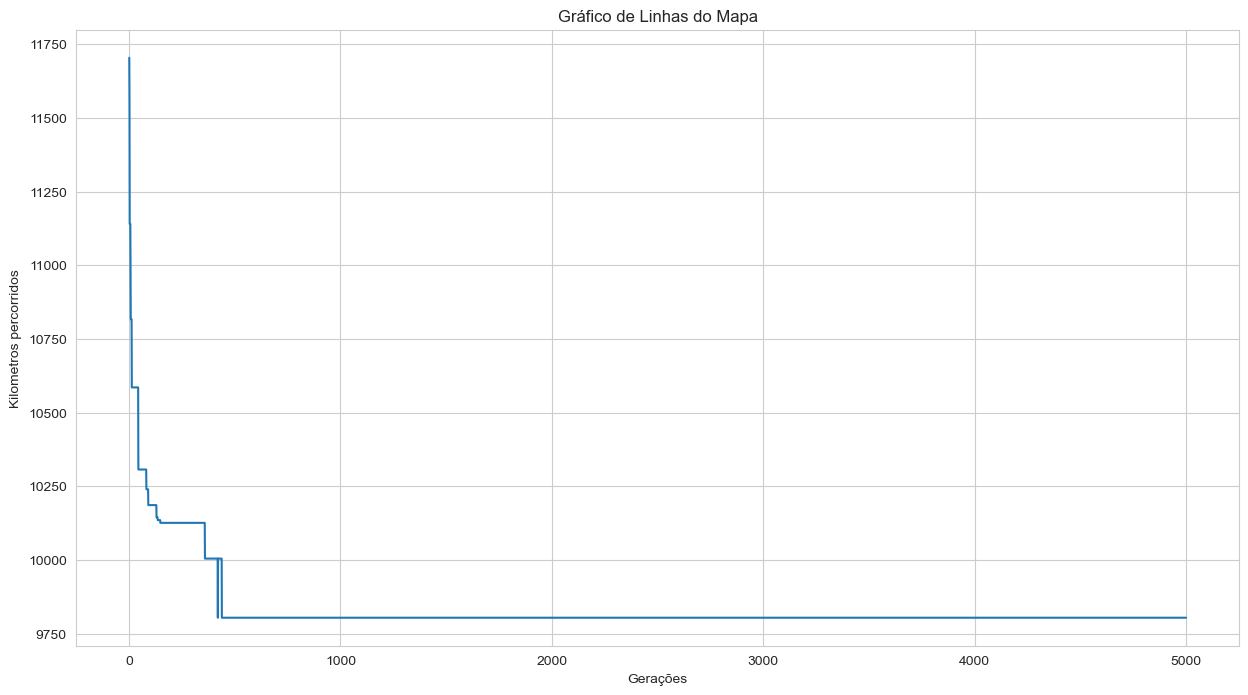

In [239]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Converter o mapa para um DataFrame
df = pd.DataFrame(list(results.items()), columns=['Gerações', 'Kilometros percorridos'])

# Aplicar a função lambda aos valores
df['Kilometros percorridos'] = df['Kilometros percorridos'].map(lambda x: x.fitness.values[0])  # Substitua 'lambda x: x' pela sua função

# Configurar o estilo do Seaborn
sns.set_style("whitegrid")

# Criar o gráfico
plt.figure(figsize=(15, 8))
sns.lineplot(x='Gerações', y='Kilometros percorridos', data=df)

# Adicionar rótulos e título
plt.xlabel('Gerações')
plt.ylabel('Kilometros percorridos')
plt.title('Gráfico de Linhas do Mapa')

# Mostrar o gráfico
plt.show()
